In [2]:

%% Ignore below lines of code, Go to next section please

tbUseProject('calibration-module');
javaaddpath(which('mpa-jutil-0.0.1-SNAPSHOT.jar'));
javaaddpath(which('java-uuid-generator-3.1.4.jar'));



Locating project "calibration-module" within "C:\Users\narayas2\Documents\MATLAB\projects".
  Found at "C:\Users\narayas2\Documents\MATLAB\projects\calibration-module".
Updating "ToolboxRegistry".
Already up-to-date.
Updating "calibration-module".
Host key verification failed. 
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
Updating "matlab-persistence".
Already up-to-date.
Found "jsonlab_v1.2" and skipping update.
Updating "logging4matlab".
Already up-to-date.
Updating "MatlabQuery".
Already up-to-date.
Updating "mdepin".
Already up-to-date.
Adding "ToolboxToolbox" to path at "C:\Users\narayas2\Documents\MATLAB\ToolboxToolbox".
Adding "calibration-module" to path at "C:\Users\narayas2\Documents\MATLAB\projects\calibration-module".
Adding "matlab-persistence" to path at "C:\Users\narayas2\Documents\MATLAB\toolboxes\matlab-persistence".
Adding "jsonlab_v1.2" to path at "C:\Users\narayas2\Documents\MATLAB\tool

In [3]:
% setup classpath

import ala_laurila_lab.*;
path = which('test-symphony-persistence.xml');
config = struct();
config.service.class = 'ala_laurila_lab.service.CalibrationService';
config.service.dataPersistence = 'test-rig-data';
config.service.logPersistence = 'test-rig-log';
config.service.persistenceXml = which('test-symphony-persistence.xml');
service = mdepin.createApplication(config, 'service');


In [4]:
%% Trying to calculate intensity to rstar
% From calibration api mode

LAMDA_MAX = 497;                        % Toda et al. 1999
ROD_PHOTORECEPTOR_AREA = 0.5 * 1e-12;   % um^2, collective area of rod (Murphy & Rieke (2011))

% get all the required instances, led names are weird but we can fix that in real calibration

intensity = service.getIntensityMeasurement('Blue');
spectrum = service.getSpectralMeasurement('blue', 'led');
linearity = service.getLinearityByStimulsDuration(5000, 'BlueLed');

% calculate rstar per second

powerPerUnitArea = intensity(end).getPowerPerUnitArea();
powerSpectrumPerArea = spectrum.getNormalizedPowerSpectrum() * powerPerUnitArea;
rstarPerSecond = util.photonToIsomerisation(powerSpectrumPerArea, spectrum.wavelength, LAMDA_MAX, ROD_PHOTORECEPTOR_AREA);

% get the transmitance value from ndf

ndf2 = service.getNDFMeasurement('A4B');
ndf3 = service.getNDFMeasurement('A1A');
trans = 10^(-(ndf2(end).opticalDensity + ndf3(end).opticalDensity));

% sample r-star table for ndf 5 

disp('ndf A1A + A4B');
disp('rstar       voltage')
disp('------------------------')

for voltage = [56.6532853243682, 90.9947797625159, 125.95670244329, 161.932053656434, 198.742115631752, 395.363673745042, 848.984144716212, 1372.9216466916]
    flux = linearity.getFluxByInput(voltage * 10^-3, 'factorized', true);
    rstar = flux * rstarPerSecond * trans;
    disp([num2str(rstar) '      ' num2str(voltage)]);
end

clear service;

ndf A1A + A4B
rstar       voltage
------------------------
1.5104      56.6533
2.4766      90.9948
3.4319      125.9567
4.3886      161.9321
5.3437      198.7421
10.1191      395.3637
19.6384      848.9841
29.0782      1372.9216



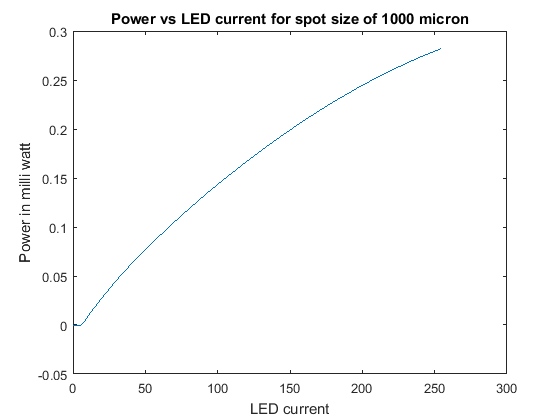

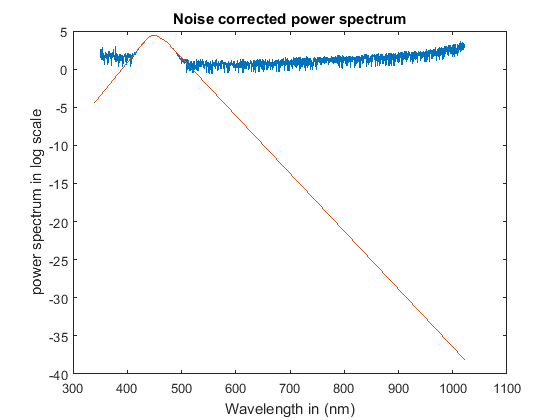

In [5]:
close all;
clc;
import ala_laurila_lab.*;

LAMDA_MAX = 497;                        % Toda et al. 1999
ROD_PHOTORECEPTOR_AREA = 0.5 * 1e-12;   % um^2, collective area of rod (Murphy & Rieke (2011))

spectrum = ala_laurila_lab.util.loadSpectralFile('src/test/resources/spectrum_aalto_rig', 'projector');
figure;

[p ,graph] = spectrum.getPowerSpectrum(25, 500, 'um');
a = axes(); graph(a)


linearity = loadjson('src\test\resources\projector-linearity.json');
figure; 
plot(linearity.ledCurrents, linearity.powerInMilliWattFor);
xlabel('LED current');
ylabel('Power in milli watt');
title('Power vs LED current for spot size of 1000 micron');


 

In [6]:
radius = 1000 * 10^-6/2;
area = pi*(radius)^2; % of 1000 um diamater

powerPerArea = @(power) power * 10^-3 / area;
powerSpectrumPerArea = @(powerPerUnitArea) spectrum.getNormalizedPowerSpectrum() * powerPerUnitArea;
rstarPerSecond = @(powerPerUnitArea) util.photonToIsomerisation(powerSpectrumPerArea(powerPerUnitArea), spectrum.wavelength, LAMDA_MAX, ROD_PHOTORECEPTOR_AREA);



fprintf('| Ledurrents \t | rstarPerSecond | ndf 1 | ndf 3 | ndf 5 |\n');
fprintf('| --------- | --------- | --------- | --------- | --------- |\n')
for i = 7 : numel(linearity.ledCurrents)
     rstar = rstarPerSecond(powerPerArea(linearity.powerInMilliWattFor(i)));  % in milli watts for 1000 micron and no ndf
     rstar = round(rstar, 2);
     fprintf('| %s \t | %s | %s \t | %s \t | %s \t |\n', num2str(linearity.ledCurrents(i)), num2str(rstar) , num2str(rstar * 10^(-1)), num2str(rstar * 10^(-3)), num2str(rstar * 10^(-5)));
end


| Ledurrents 	 | rstarPerSecond | ndf 1 | ndf 3 | ndf 5 |
| --------- | --------- | --------- | --------- | --------- |
| 6 	 | 137030.47 | 13703.047 	 | 137.0305 	 | 1.3703 	 |
| 7 	 | 1636321.41 | 163632.141 	 | 1636.3214 	 | 16.3632 	 |
| 8 	 | 3420181.9 | 342018.19 	 | 3420.1819 	 | 34.2018 	 |
| 9 	 | 5623178 | 562317.8 	 | 5623.178 	 | 56.2318 	 |
| 10 	 | 7408572.94 | 740857.294 	 | 7408.5729 	 | 74.0857 	 |
| 11 	 | 9169695.77 | 916969.577 	 | 9169.6958 	 | 91.697 	 |
| 12 	 | 10971411.61 | 1097141.161 	 | 10971.4116 	 | 109.7141 	 |
| 13 	 | 12818835.27 | 1281883.527 	 | 12818.8353 	 | 128.1884 	 |
| 14 	 | 14495377.7 | 1449537.77 	 | 14495.3777 	 | 144.9538 	 |
| 15 	 | 16147694.53 | 1614769.453 	 | 16147.6945 	 | 161.4769 	 |
| 20 	 | 24654557.14 | 2465455.714 	 | 24654.5571 	 | 246.5456 	 |
| 30 	 | 40715578.84 | 4071557.884 	 | 40715.5788 	 | 407.1558 	 |
| 40 	 | 55189474.32 | 5518947.432 	 | 55189.4743 	 | 551.8947 	 |
| 50 	 | 68913026.87 | 6891302.687 	 | 68913.0269 	 